In [11]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [175]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip



from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily,\
      CountMinSketchHadamard, CountMinSketchLocalHashing, deterministic_hash, simple_deterministic_hash
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, filter_df, query_df, \
      infer_domains_and_ranges, translate_query_region, evaluate_queries, check_accruracy, \
      evaluate_queries_baselines

# set_style()

In [13]:
delta = 0.05
abs_error_eps = 1.0

# Online Retail

In [14]:
retail_df = pd.read_parquet("../data/clean/online_retail.parquet")

In [ ]:
query_path = "../queries/online_retail_2_cols.json"
with open(query_path, 'rb') as f:
    queries = orjson.loads(f.read())

query_path = "../queries/online_retail_4_cols.json"
with open(query_path, 'rb') as f:
    queries_4 = orjson.loads(f.read())

ad_tree = ADTree.from_json("../sketches/ad_trees/online_retail.json")


# Pacha Sketches

## Normal

In [21]:
p_sketch = PachaSketch.build_with_uniform_size(
    levels=5,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
    num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01))
p_sketch.get_size()

95.50641822814941

In [22]:
p_sketch.update_data_frame(retail_df, workers=os.cpu_count())

Updating: 100%|██████████| 541909/541909 [04:18<00:00, 2093.36it/s]


In [44]:
p_sketch.save_to_file("../sketches/real_world/online_retail_uniform.json.gz")

In [ ]:
p_sketch2 = PachaSketch.from_json("../sketches/real_world/online_retail_uniform.json.gz")

In [28]:
results_df = evaluate_queries(retail_df, queries["queries"], p_sketch, path_to_file="../results/real_world/online_retail_2_p_sketch_uniform.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 43.34it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [23:24<00:00,  7.02s/it]


In [64]:
results_df[["absolute_error","normalized_error","relative_error","query_regions"]].describe()

,absolute_error,normalized_error,relative_error,query_regions
count,200.000000,200.000000,200.000000,200.000000
mean,1495.020000,0.002759,0.030890,13075.100000
std,3284.357086,0.006061,0.039216,22529.014215
min,3.000000,0.000006,0.003227,113.000000
25%,34.750000,0.000064,0.007233,546.750000
50%,206.000000,0.000380,0.012420,1768.000000
75%,862.250000,0.001591,0.052554,16739.500000
max,16057.000000,0.029630,0.247638,103413.000000


In [46]:
results_df_4 = evaluate_queries(retail_df, queries_4["queries"], p_sketch, path_to_file="../results/real_world/online_retail_4_p_sketch_uniform.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 30.75it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [03:31<00:00,  1.06s/it]


In [65]:
results_df_4[["absolute_error","normalized_error","relative_error","query_regions"]].describe()

/home/rudi/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,absolute_error,normalized_error,relative_error,query_regions
count,200.000000,200.000000,195.000000,200.000000
mean,164.525000,0.000304,inf,1186.780000
std,438.239671,0.000809,NaN,3040.415082
min,0.000000,0.000000,0.000000,0.000000
25%,24.750000,0.000046,0.041999,212.000000
50%,45.500000,0.000084,0.063565,352.000000
75%,96.250000,0.000178,0.087964,597.750000
max,2792.000000,0.005152,inf,18121.000000


## Differentially Private

In [103]:
p_sketch_dp = PachaSketch.build_with_uniform_size(
    levels=5,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
    num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01),
    epsilon=5.0
    )
p_sketch_dp.get_size()

95.50641822814941

In [110]:
p_sketch_dp.update_data_frame(retail_df, workers=os.cpu_count())

Updating: 100%|██████████| 541909/541909 [09:16<00:00, 973.82it/s] 


In [111]:
ps_results_2 = evaluate_queries(retail_df, queries["queries"], p_sketch_dp, path_to_file="../results/real_world/online_retail_2_p_sketch_uniform_dp_5.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 40.12it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [1:37:04<00:00, 29.12s/it]  


In [ ]:
ps_results_4 = evaluate_queries(retail_df, queries_4["queries"], p_sketch_dp, path_to_file="../results/real_world/online_retail_4_p_sketch_uniform_dp_5.csv")

# Baselines

## Central DP

In [89]:
epsilon = 5.0
per_query_epsilon=epsilon/(len(queries["queries"])+1)
central_dp = CentralDPServer(retail_df, epsilon=epsilon, per_query_epsilon=per_query_epsilon)

central_dp_results_2 = evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=central_dp, path_to_file="../results/real_world/online_retail_2_central_dp_5.csv")
central_dp.reset_budget()
central_dp_results_4 = evaluate_queries_baselines(df=retail_df, queries=queries_4["queries"], baseline=central_dp, path_to_file="../results/real_world/online_retail_4_central_dp_5.csv")
central_dp.reset_budget()

Computing true counts...


True Count: 100%|██████████| 200/200 [00:05<00:00, 36.90it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:05<00:00, 36.51it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:08<00:00, 22.98it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 24.92it/s]


In [90]:
central_dp_results_2[["absolute_error","normalized_error","relative_error"]].describe()

,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,200.000000
mean,41.945000,0.000077,0.010200
std,43.599271,0.000080,0.025772
min,0.000000,0.000000,0.000000
25%,12.000000,0.000022,0.000342
50%,32.000000,0.000059,0.002145
75%,58.250000,0.000107,0.009703
max,267.000000,0.000493,0.261324


In [91]:
central_dp_results_4[["absolute_error","normalized_error","relative_error"]].describe()

/home/rudi/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,196.000000
mean,42.135000,0.000078,inf
std,41.330836,0.000076,NaN
min,0.000000,0.000000,0.000045
25%,11.750000,0.000022,0.010163
50%,28.000000,0.000052,0.029956
75%,60.000000,0.000111,0.092788
max,229.000000,0.000423,inf


## Local DP

In [92]:
epsilon = 5.0
per_query_epsilon=epsilon/(len(queries["queries"])+1)
ldp = LDPServer(retail_df, epsilon=epsilon, number_of_partitions=10, per_query_epsilon=per_query_epsilon)

ldp_results_2 = evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=ldp, path_to_file="../results/real_world/online_retail_2_ldp_5.csv")
ldp.reset_budget()
ldp_results_4 = evaluate_queries_baselines(df=retail_df, queries=queries_4["queries"], baseline=ldp, path_to_file="../results/real_world/online_retail_4_ldp_5.csv")
ldp.reset_budget()

Computing true counts...


True Count:   0%|          | 0/200 [00:00<?, ?it/s]

True Count: 100%|██████████| 200/200 [00:04<00:00, 42.02it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:06<00:00, 31.73it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 29.51it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:09<00:00, 21.67it/s]


In [93]:
ldp_results_2[["absolute_error","normalized_error","relative_error"]].describe()

,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,200.000000
mean,39521.200000,0.072930,0.840484
std,54223.788555,0.100061,0.209928
min,56.000000,0.000103,0.050088
25%,2936.250000,0.005418,0.794086
50%,5668.500000,0.010460,0.930375
75%,79390.000000,0.146501,0.977298
max,191591.000000,0.353548,1.000000


In [94]:
ldp_results_4[["absolute_error","normalized_error","relative_error"]].describe()

/home/rudi/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,198.000000
mean,2883.770000,0.005322,inf
std,7874.113824,0.014530,NaN
min,0.000000,0.000000,0.141414
25%,347.750000,0.000642,0.885487
50%,836.500000,0.001544,0.998182
75%,1569.500000,0.002896,1.000000
max,45603.000000,0.084153,inf


## Local DP - GRR

In [95]:
epsilon = 5.0
categorical_domains, numerical_ranges = infer_domains_and_ranges(retail_df)

grr = LDPEncoderGRR(df=retail_df, epsilon=epsilon, categorical_domains=categorical_domains, numerical_ranges=numerical_ranges)

grr_results_2 = evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=grr, path_to_file="../results/real_world/online_retail_2_grr_5.csv")
grr_results_4 = evaluate_queries_baselines(df=retail_df, queries=queries_4["queries"], baseline=grr, path_to_file="../results/real_world/online_retail_4_grr_5.csv")

Privatizing rows: 100%|██████████| 541909/541909 [02:38<00:00, 3429.36it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:05<00:00, 36.36it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:07<00:00, 27.63it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 26.52it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:11<00:00, 17.18it/s]


In [96]:
grr_results_2[["absolute_error","normalized_error","relative_error"]].describe()

,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,200.000000
mean,44468.655000,0.082059,0.930654
std,62673.184972,0.115653,0.257347
min,16.000000,0.000030,0.042328
25%,3323.750000,0.006133,0.887105
50%,6230.500000,0.011497,0.960060
75%,83535.000000,0.154149,0.987321
max,219330.000000,0.404736,4.100422


In [97]:
grr_results_4[["absolute_error","normalized_error","relative_error"]].describe()

/home/rudi/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,196.00000
mean,2962.560000,0.005467,inf
std,7907.365946,0.014592,NaN
min,0.000000,0.000000,0.00000
25%,413.250000,0.000763,0.99875
50%,963.500000,0.001778,1.00000
75%,1700.750000,0.003138,1.00000
max,45572.000000,0.084095,inf


# Plots

In [124]:
p_sketch.query(queries["queries"][0], True, True)

Categorical regions: 125
Indexed categorical regions: 125
Numerical regions: 1396
Indexed numerical regions: 947
Candidate regions: 118375
Query regions: 15636
Level 0 queries: 531
Level 1 queries: 2012
Level 2 queries: 3145
Level 3 queries: 9948
Estimate: 122753


(122753,
 {'cat_regions': 125,
  'num_regions': 947,
  'query_regions': 15636,
  'queries_per_level': [531, 2012, 3145, 9948, 0]})

In [123]:
queries["queries"][1]

[['226'], '*', '*', [93, 170], '*', '*']

In [120]:
retail_df.describe()

,date,age,total
count,541909.000000,541909.000000,541909.000000
mean,151.535738,35.104582,20.881216
std,88.132067,7.753374,378.638866
min,0.000000,18.000000,0.000000
25%,74.000000,31.000000,3.000000
50%,150.000000,34.000000,9.000000
75%,228.000000,39.000000,17.000000
max,304.000000,71.000000,168469.000000


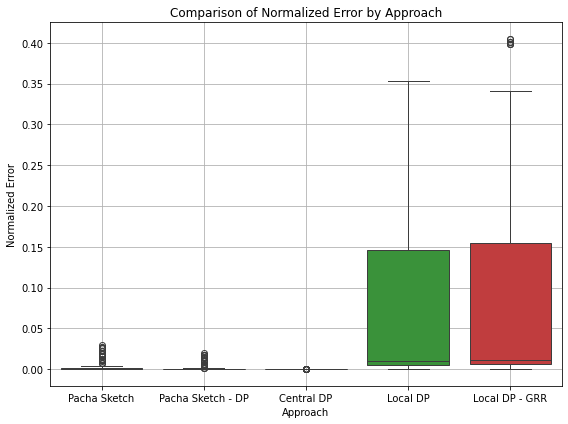

In [129]:
# Label the sources as '2' and '4' (corresponding to number of predicates)
results_df['approach'] = 'Pacha Sketch'
ps_results_2['approach'] = 'Pacha Sketch - DP'
central_dp_results_2['approach'] = 'Central DP'
ldp_results_2['approach'] = 'Local DP'
grr_results_2['approach'] = 'Local DP - GRR'

custom_palette = {
    'Pacha Sketch': 'tab:blue',
    'Pacha Sketch - DP': 'tab:purple', 
    'Central DP': 'tab:orange',
    'Local DP': 'tab:green',
    'Local DP - GRR': 'tab:red'
    }

# Combine the DataFrames
combined_df = pd.concat([results_df,ps_results_2, central_dp_results_2, ldp_results_2, grr_results_2], ignore_index=True)

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='approach', y='normalized_error', hue='approach', data=combined_df, palette=custom_palette)

# Set axis labels and title
plt.xlabel('Approach')
plt.ylabel('Normalized Error')
plt.title('Comparison of Normalized Error by Approach')
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  
plt.show()

In [119]:
CMParameters(width=10, depth=3, epsilon=5.0/200.0).build_sketch().counters

array([[ 125,    3,    0,  -77,  -25,    0,   18,   37,  -11,  -81],
       [ -22,   68,  -34,   -4,   79, -120,    9,   92,  -31,    4],
       [  68,  -53,    2,   28,   17,   -3,  -36,   -1,  -12,   -2]])

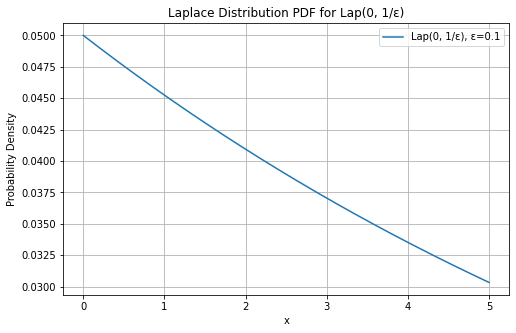

In [116]:
from scipy.stats import laplace

eps = 0.1  # example epsilon, you can change this value
b = 1 / eps
x_vals = np.linspace(0, 5, 500)
pdf_vals = laplace.pdf(x_vals, loc=0, scale=b)

plt.figure(figsize=(8, 5))
plt.plot(x_vals, pdf_vals, label=f'Lap(0, 1/ε), ε={eps}')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Laplace Distribution PDF for Lap(0, 1/ε)')
plt.grid(True)
plt.legend()
plt.show()

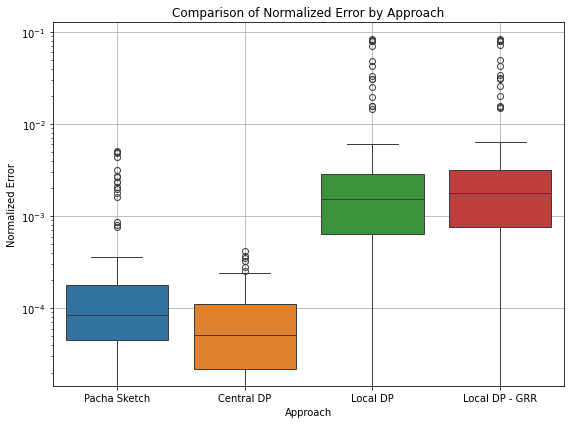

In [100]:
# Label the sources as '2' and '4' (corresponding to number of predicates)
results_df_4['approach'] = 'Pacha Sketch'
central_dp_results_4['approach'] = 'Central DP'
ldp_results_4['approach'] = 'Local DP'
grr_results_4['approach'] = 'Local DP - GRR'

custom_palette = {
    'Pacha Sketch': 'tab:blue', 
    'Central DP': 'tab:orange',
    'Local DP': 'tab:green',
    'Local DP - GRR': 'tab:red'
    }

# Combine the DataFrames
combined_df = pd.concat([results_df_4, central_dp_results_4, ldp_results_4, grr_results_4], ignore_index=True)

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='approach', y='normalized_error', hue='approach', data=combined_df, palette=custom_palette)

# Set axis labels and title
plt.xlabel('Approach')
plt.ylabel('Normalized Error')
plt.title('Comparison of Normalized Error by Approach')
plt.grid(True)
plt.tight_layout()
plt.yscale('log')  
plt.show()

# Performance Improvements

In [176]:
p_sketch_new = PachaSketch.build_with_uniform_size(
    levels=5,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
    num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01))

In [177]:
p_sketch_new.numerical_bitmaps = p_sketch.numerical_bitmaps

In [ ]:
b_cubes = p_sketch.minimal_spatial_b_adic_cover([[93, 170], (18, 71), (0, 168469)])


In [178]:
import time

# Define the test input
test_region = [[93, 170], (18, 71), (0, 168469)]

# Time the original method
start_time = time.time()
result_old = p_sketch.minimal_spatial_b_adic_cover(test_region)
old_time = time.time() - start_time

# Time the new method
start_time = time.time()
result_new = p_sketch_new.new_minimal_spatial_b_adic_cover(test_region)
new_time = time.time() - start_time

# Compare results for equivalence
are_equivalent = (result_old == result_new)

print(f"Old method time: {old_time:.6f} seconds")
print(f"New method time: {new_time:.6f} seconds")
print(f"Results equivalent: {are_equivalent}")


Old method time: 7.675838 seconds
New method time: 4.903668 seconds
Results equivalent: [ True  True  True ...  True  True  True]
